In [13]:
from differences import ATTgt
from matplotlib import pyplot as plt
plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
from panel_utilities import get_value_variable_names, prepare_df_for_DiD
from stats_utilities import select_controls, test_balance, produce_summary_statistics
from figure_utilities import aggregate_by_event_time_and_plot, aggregate_by_time_and_plot
import pandas as pd



# Store paths.
analysis='group_0_crimes_500m'
INPUT_DATA = "../../data/03_cleaned/crime_analysis_monthly.parquet"
OUTPUT_FIGURES = f"../../output/group_0_crimes_warm_500m/figures"
OUTPUT_TABLES = f"../../output/group_0_crimes_warm_500m/tables"


# Read restricted sample panel dataset into memory.
df = pd.read_parquet(INPUT_DATA)

In [14]:
# Convert weekly panel to biweekly panel.
treatment_date_variable = 'latest_docket_month'
df = df.dropna(subset=treatment_date_variable)

# Generate value vars list and month to int dictionaries.
weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)

In [15]:
pre_pandemic_months = ['2019-05'
                       '2019-06',
                       '2019-07',
                       '2019-08',
                       '2019-09',
                       '2019-10']

df = df.loc[df['latest_docket_month'].isin(pre_pandemic_months), :]

In [16]:
covariates_exploration_df = select_controls(df=df, analysis=analysis,
                                            treatment_date_variable=treatment_date_variable,
                                            output_directory=OUTPUT_TABLES)
covariates_exploration_df

Dependent Variable  \
                                                                                                                  
                                                 \emph{Independent Variable}                                      
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_0_crimes_500m       4.651325e-186   
                                                 pre_treatment_change_in_group_0_crimes_500m       5.267210e-13   
Panel B: Census Tract Characteristics            frac_coll_plus2010                                1.529976e-02   
                                                 job_density_2013                                  2.713897e-26   
                                                 med_hhinc2016                                     1.276731e-01   
                                                 poor_share2010                                    5.717668e-10   
                                                 popdensity2010                                    1.077692e-09   
Panel C: Case Initiation                         for_cause                                         7.134413e-01   
                                                 no_cause                                          1.076849e-01   
                                                 non_payment                                       9.453556e-04   
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                          1.912401e-01   
                                                 hasAttyP                                          6.983698e-01   
                                                 isEntityD                                         1.067189e-04   
                                                 isEntityP                                         1.946893e-01   

                                                                                                        
                                                                                                        
                                                 \emph{Independent Variable}                            
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_0_crimes_500m   0.054036  
                                                 pre_treatment_change_in_group_0_crimes_500m  0.933847  
Panel B: Census Tract Characteristics            frac_coll_plus2010                           0.633797  
                                                 job_density_2013                             0.564473  
                                                 med_hhinc2016                                0.189213  
                                                 poor_share2010                               0.000026  
                                                 popdensity2010                               0.143374  
Panel C: Case Initiation                         for_cause                                    0.006291  
                                                 no_cause                                     0.750421  
                                                 non_payment                                  0.000005  
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                     0.001152  
                                                 hasAttyP                                     0.071277  
                                                 isEntityD                                    0.036681  
                                                 isEntityP                                    0.003123

In [17]:
balance_table, pre_treatment_covariates = test_balance(df, analysis, covariates_exploration_df, OUTPUT_TABLES)
balance_table

\
                                             Cases Won by Plaintiff   
Panel A Total Crime Incidents, 2017                     1093.640449   
        Change in Crime Incidents, 2017-2019            -141.216292   
Panel B Bachelor's degree, 2010                            0.323187   
        Job density, 2013                              17314.676754   
        Poverty rate, 2010                                 0.257101   
        Population density, 2010                       22735.013758   
Panel C Filing for nonpayment                              0.685393   
Panel D Defendant is entity                                0.030899   

                                             Difference in Cases Won by Defendant  \
                                                                       Unweighted   
Panel A Total Crime Incidents, 2017                                   -110.143723   
        Change in Crime Incidents, 2017-2019                             1.463564   
Panel B Bachelor's degree, 2010                                          0.008321   
        Job density, 2013                                             1979.242039   
        Poverty rate, 2010                                              -0.048751   
        Population density, 2010                                     -1740.528738   
Panel C Filing for nonpayment                                           -0.156333   
Panel D Defendant is entity                                              0.023705   

                                                                               
                                              \emph{p}     Weighted  \emph{p}  
Panel A Total Crime Incidents, 2017           0.054036  -136.353484  0.017695  
        Change in Crime Incidents, 2017-2019  0.933847    15.377244  0.378535  
Panel B Bachelor's degree, 2010               0.633797    -0.033153  0.016509  
        Job density, 2013                     0.564473 -1508.221493  0.652552  
        Poverty rate, 2010                    0.000026    -0.036049  0.001270  
        Population density, 2010              0.143374 -2738.607110  0.019832  
Panel C Filing for nonpayment                 0.000005    -0.100709  0.001229  
Panel D Defendant is entity                   0.036681     0.000833  0.931602

In [18]:
# Generate indicators for missing data.

# missing_indicators = add_missing_indicators(df, ['rent_twobed2015'], pre_treatment_covariates)

# Prepare df for use with the differences package.
df = df.reset_index()
df = prepare_df_for_DiD(df=df,
                        analysis=analysis,
                        treatment_date_variable=treatment_date_variable,
                        pre_treatment_covariates=pre_treatment_covariates,
                        missing_indicators=[],
                        value_vars=weekly_value_vars_crime,
                        period_to_int_dictionary=month_to_int_dictionary)

In [19]:
# Run DiD without conditioning on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, freq='2W', base_period='universal')
result = att_gt.fit(formula=analysis, control_group='not_yet_treated', n_jobs=-1)

Computing ATTgt [workers=10]  100%|████████████████████| 368/368 [00:04<00:00, 74.73it/s] 


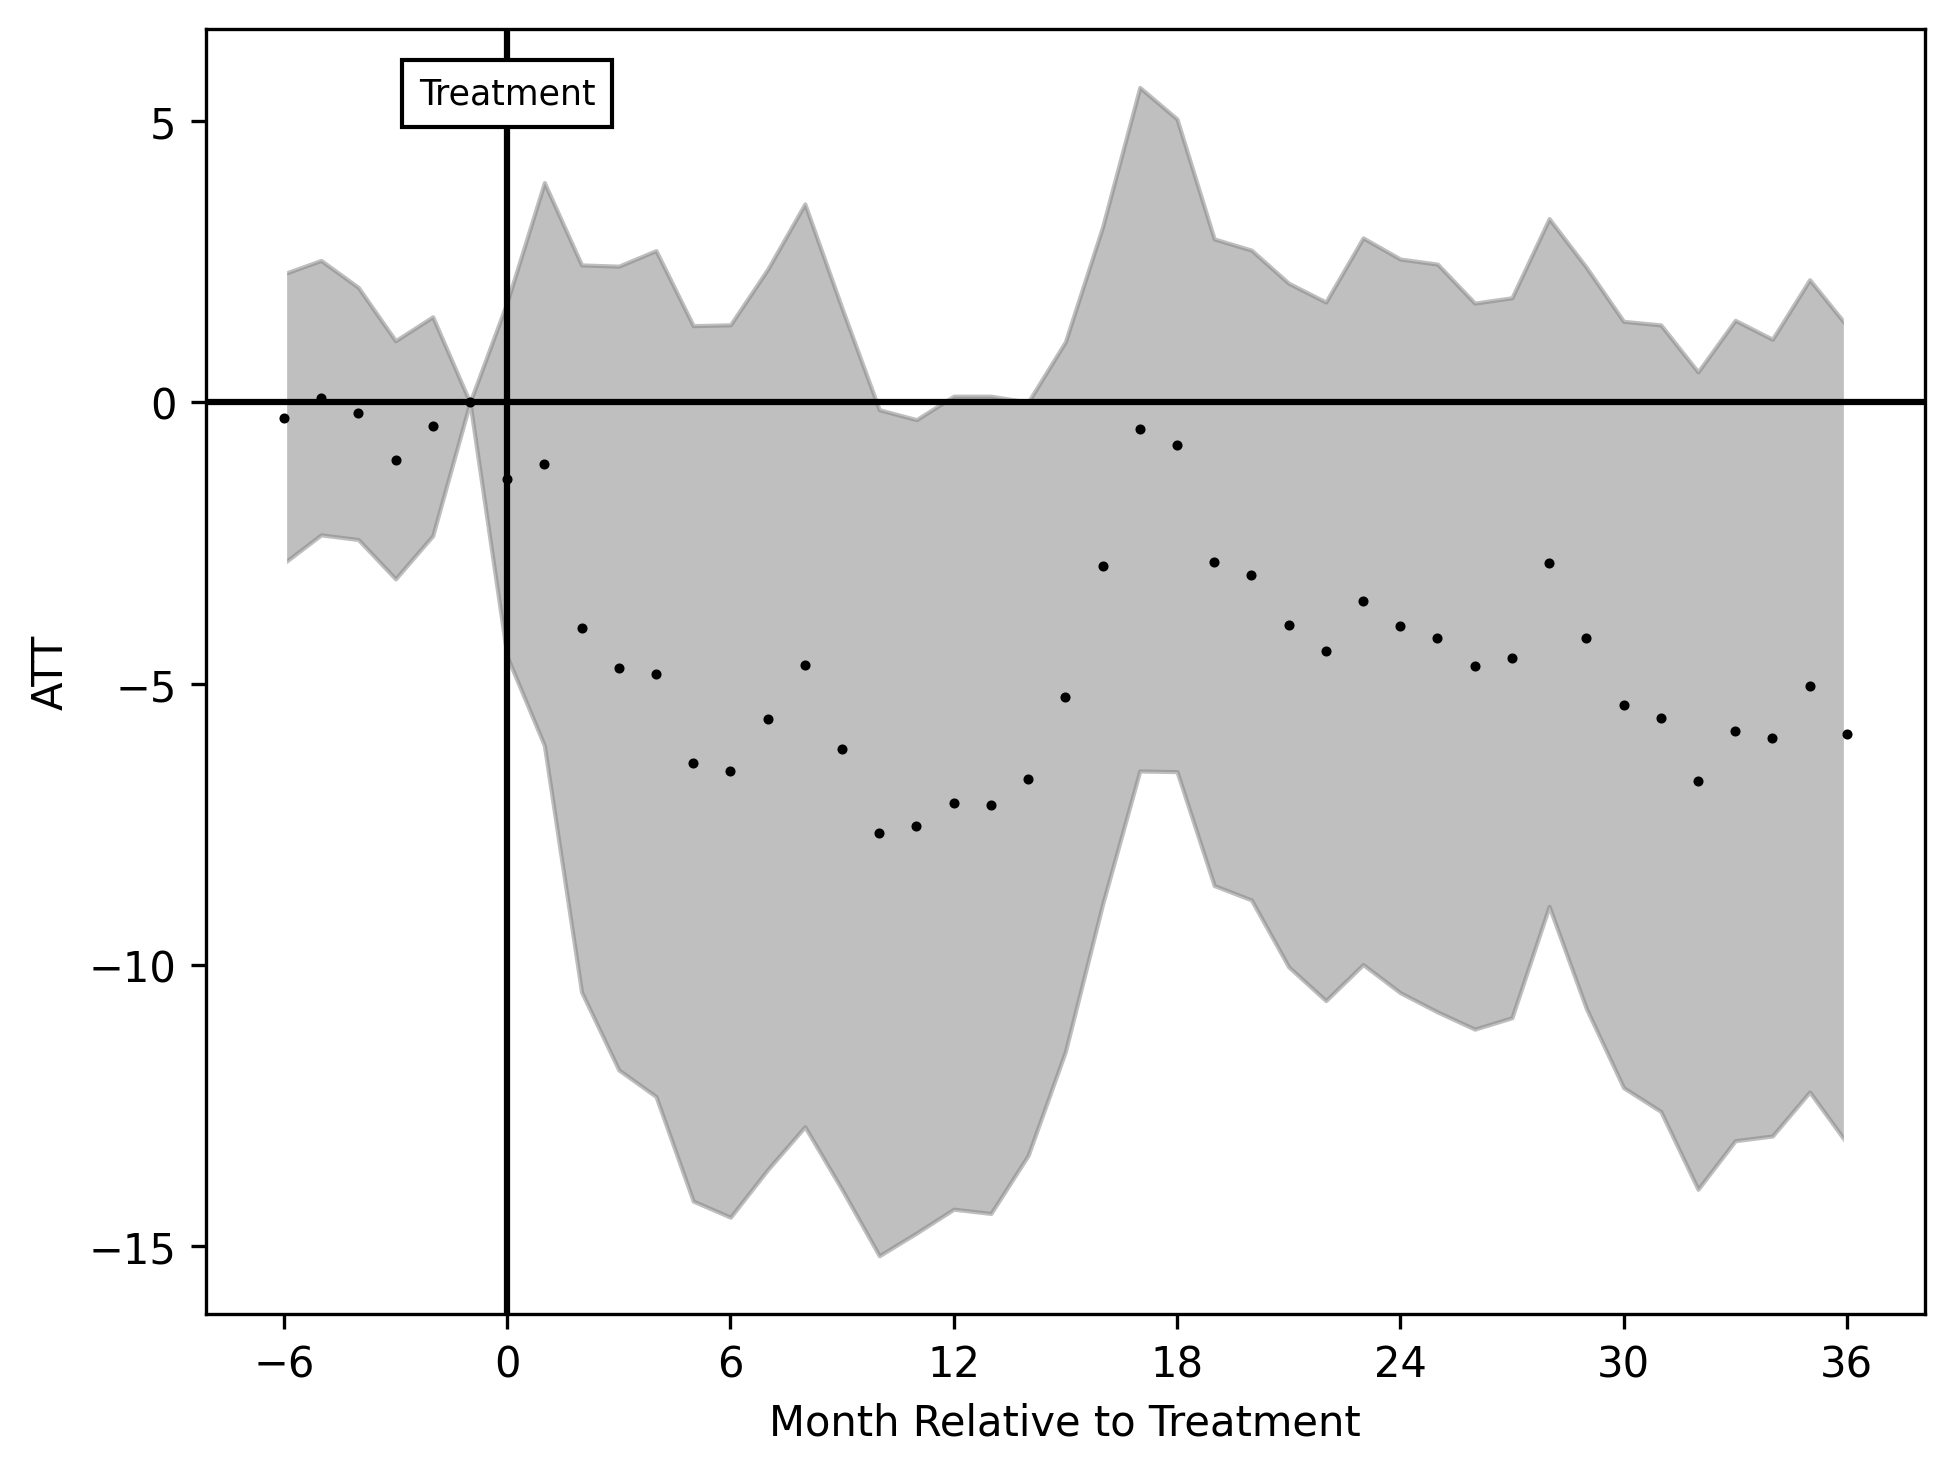

In [20]:
# Plot unconditional ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_unconditional_event_study_long_horizon.png",
                                 start_period=-6, end_period=36,
                                 title="",
                                 treatment_month_variable=treatment_date_variable, df=df)

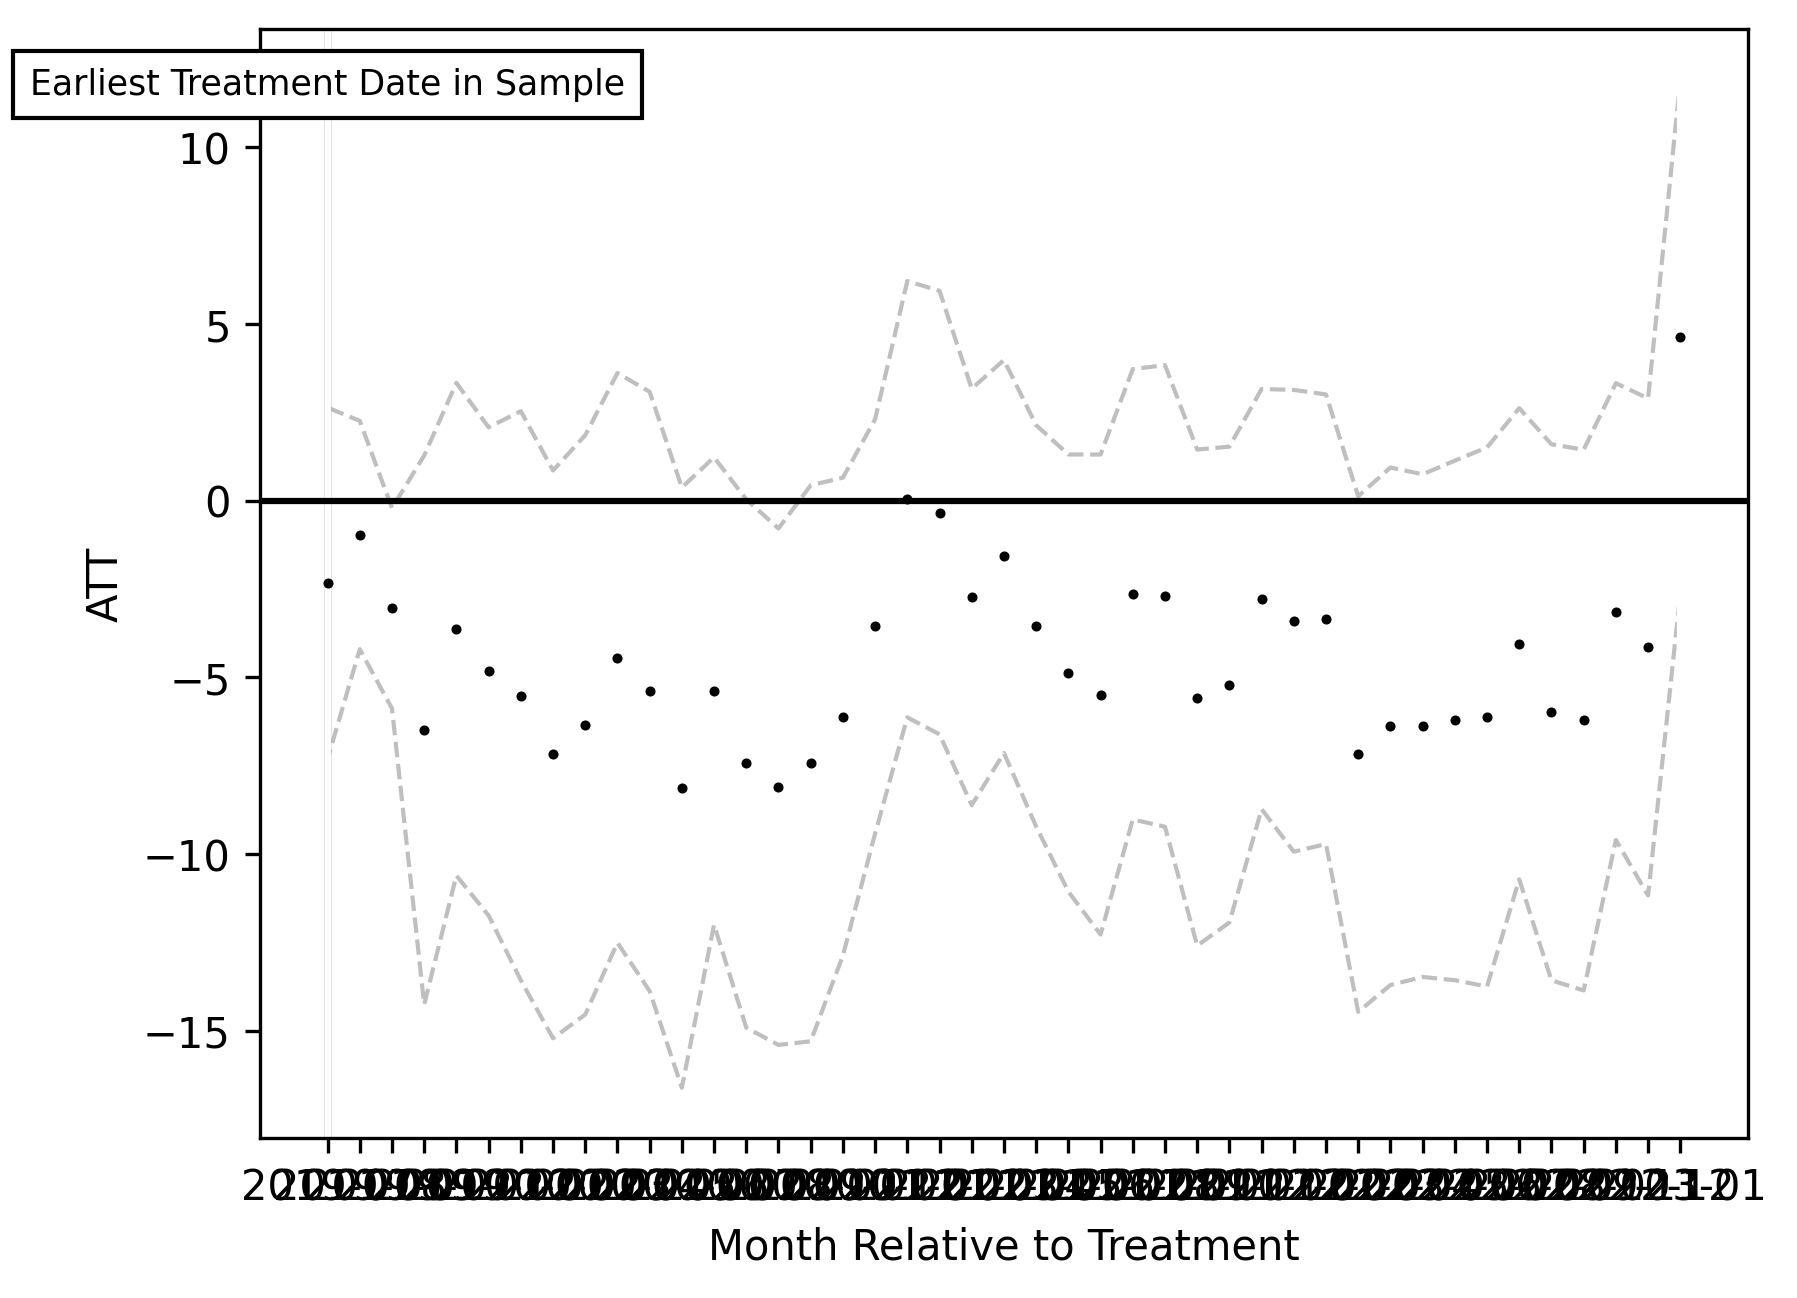

In [21]:
# Plot unconditional ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_unconditional_time.png",
                           title="")

In [22]:
# Run DiD conditional on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, freq='M', base_period='universal')
formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
result = att_gt.fit(formula=formula, control_group='not_yet_treated', n_jobs=-1, progress_bar=True)

Computing ATTgt [workers=10]  100%|████████████████████| 368/368 [00:11<00:00, 32.69it/s]


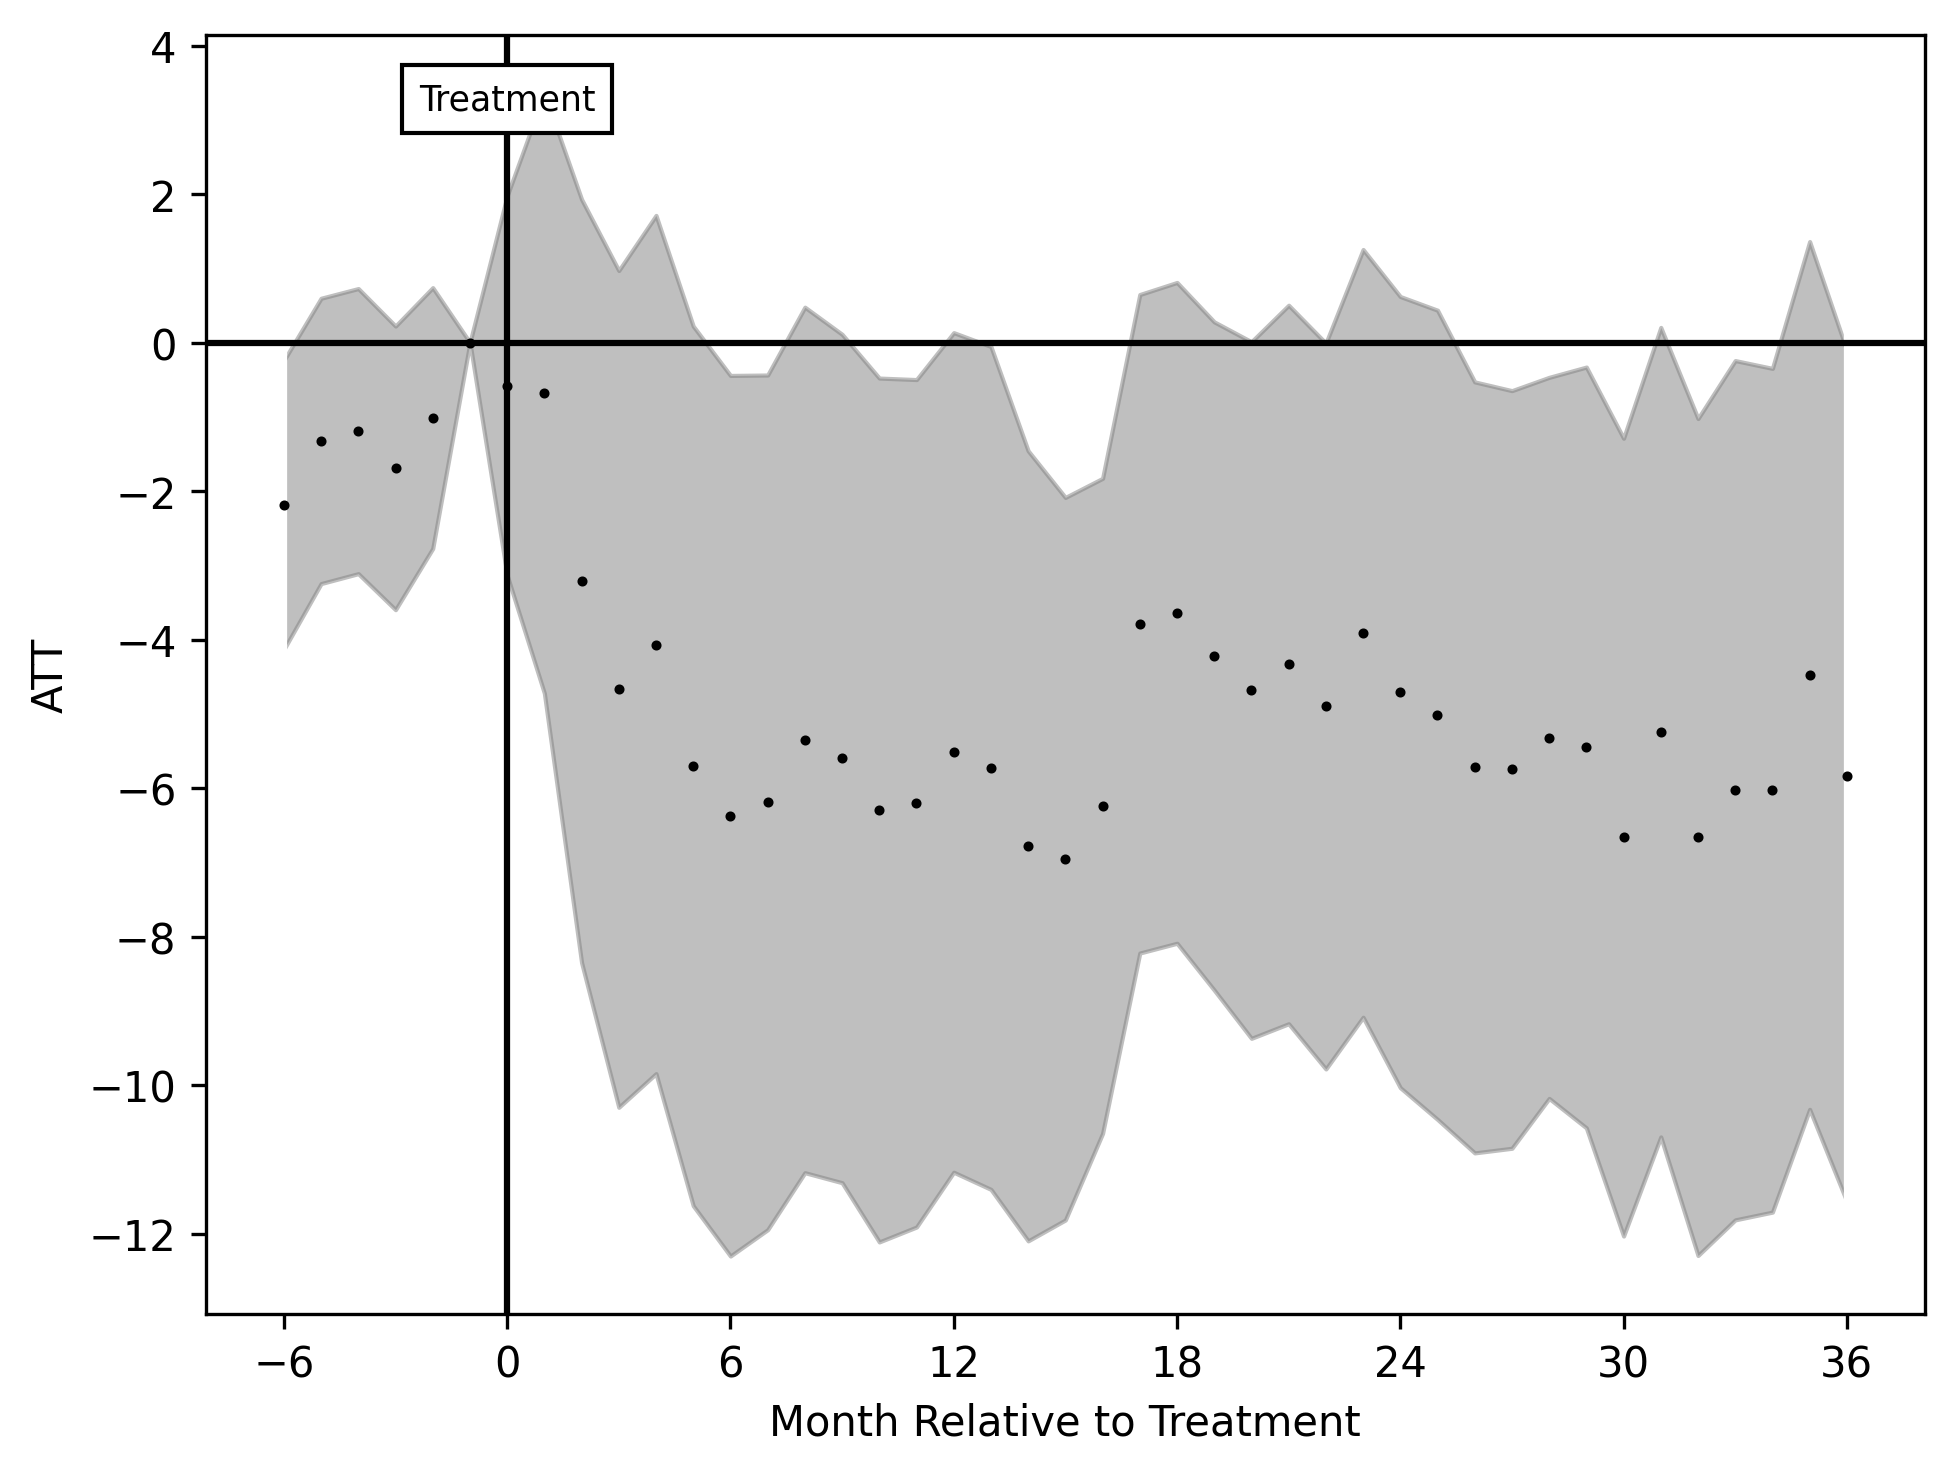

In [23]:
# Plot D.R. ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_dr_event_study_long_horizon.png", start_period=-6,
                                 end_period=36,
                                 title="",
                                 treatment_month_variable=treatment_date_variable, df=df)

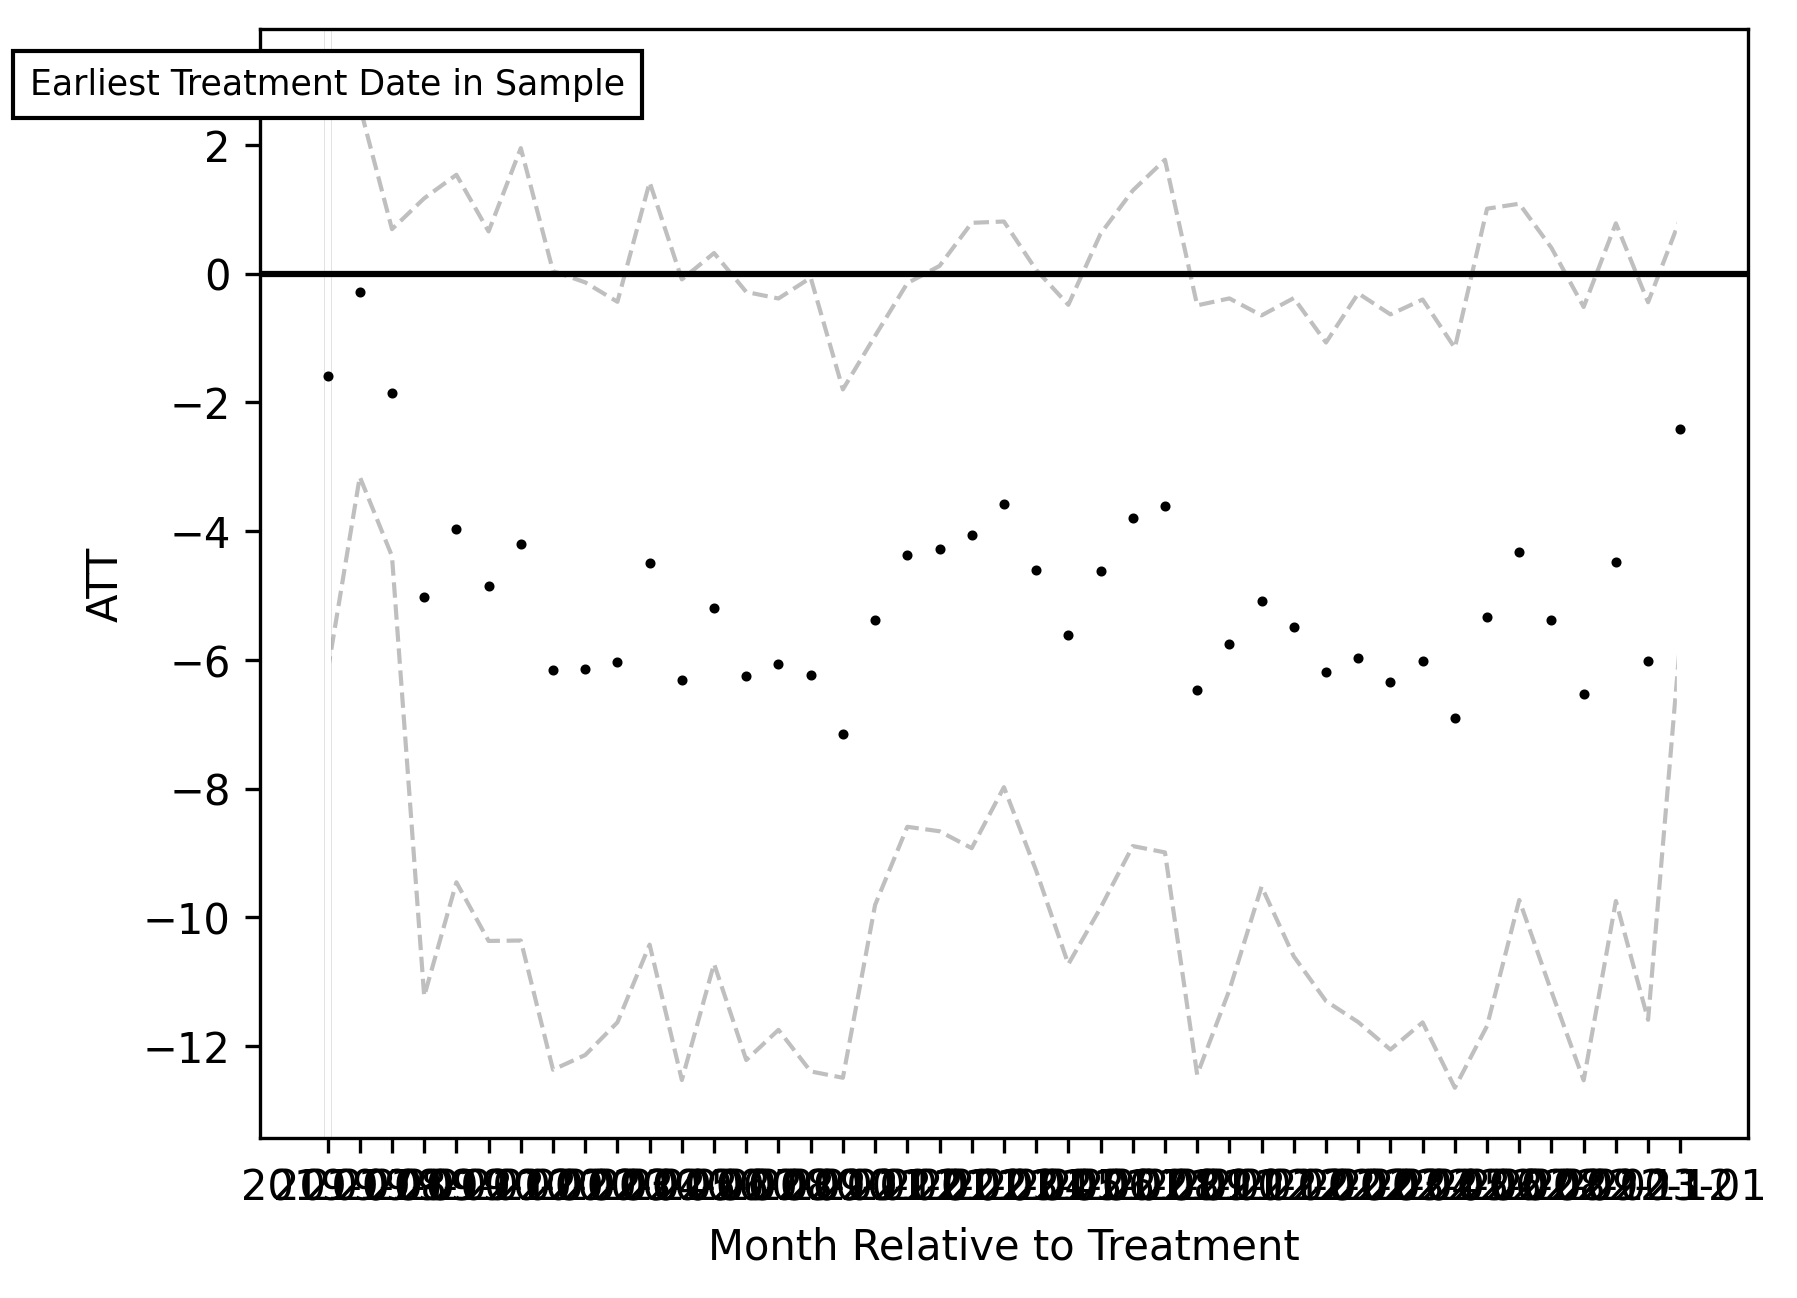

In [24]:
# Plot D.R. ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_dr_time.png",
                           title="")